In [29]:
%matplotlib notebook

import os
import sys
sys.path.append("..")
import re

import tensorflow as tf
from tensorflow import keras
from tensorboard.backend.event_processing import event_accumulator

import numpy as np
import scipy as sp
import pandas as pd
from PIL import Image
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append('../scripts')
import scripts.training_config as training_config
import scripts.filepaths as filepaths

import warnings

In [298]:
def get_val_event_log(base_dir):
    tb_str = base_dir+'/tensorboard/validation/'
    if os.path.exists(tb_str):
        logs = os.listdir(tb_str)
        for file in logs:
            matches = re.search('events.out.tfevents.*',file)
            if(matches is not None):
                return tb_str+file
            
def get_train_event_log(base_dir):
    tb_str = base_dir+'/tensorboard/train/'
    if os.path.exists(tb_str):
        logs = os.listdir(tb_str)
        for file in logs:
            matches = re.search('events.out.tfevents.*',file)
            if(matches is not None and 'profile-empty' not in file):
                return tb_str+file

In [469]:
base_dir = filepaths.TRAIN_DIR
tasks = ['undersample','motion','denoise']
window = 50
val_img_l1 = pd.DataFrame()

for task in tasks:
    exp = 'nonlinear_comparison_compimage_'+task
    if('motion' in exp):
        exp = 'nonlinear_comparison_compimage_motion'

    exp_dir = os.path.join(base_dir,exp)
    for folder in os.listdir(exp_dir):
        fol_dir = os.path.join(exp_dir,folder)
        log = get_val_event_log(fol_dir)
        if(log is not None):
            match = re.search('MRI-.*-FREQ-(.*)-5000-8',folder).group(1)
            if('relu' in match):
                nonlinear='ReLU'
            elif('3-piece' in match):
                nonlinear='Custom'
            x = event_accumulator.EventAccumulator(path=get_val_event_log(fol_dir),size_guidance={event_accumulator.SCALARS: 0},purge_orphaned_data=False)
            x.Reload()
            img_l1 = pd.DataFrame({'l1':pd.DataFrame(x.Scalars('epoch_image_l1')).value})[::5]
            img_l1['l1'] = img_l1['l1'].rolling(window,center=True).mean().shift(-window)
            img_l1['Nonlinearity'] = nonlinear
            img_l1['task'] = task
            val_img_l1 = pd.concat([val_img_l1,img_l1], axis=0)

train_img_l1 = pd.DataFrame()

for task in tasks:
    exp = 'nonlinear_comparison_compimage_'+task
    if('motion' in exp):
        exp = 'nonlinear_comparison_compimage_motion'
    exp_dir = os.path.join(base_dir,exp)
    
    for folder in os.listdir(exp_dir):
        fol_dir = os.path.join(exp_dir,folder)
        log = get_train_event_log(fol_dir)
        if(log is not None):
            match = re.search('MRI-.*-FREQ-(.*)-5000-8',folder).group(1)
            if('relu' in match):
                nonlinear='ReLU'
            elif('3-piece' in match):
                nonlinear='Custom'
            x = event_accumulator.EventAccumulator(path=get_train_event_log(fol_dir),size_guidance={event_accumulator.SCALARS: 0},purge_orphaned_data=False)
            x.Reload()
            img_l1 = pd.DataFrame({'l1':pd.DataFrame(x.Scalars('epoch_image_l1')).value})[::5]
            img_l1['l1'] = img_l1['l1'].rolling(window,center=True).mean().shift(-window)
            img_l1['Nonlinearity'] = nonlinear
            img_l1['task'] = task
            train_img_l1 = pd.concat([train_img_l1,img_l1], axis=0)


MRI-undersample-0.75-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-relu-5000-8
MRI-undersample-0.75-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-3-piece-5000-8
MRI-motion-0.03-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-relu-5000-8
MRI-motion-0.03-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-3-piece-5000-8
MRI-noise-10000.0-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-relu-5000-8
MRI-noise-10000.0-CONV_RESIDUAL-9-32-16-compimage-L1-0.1-FREQ-FREQ-3-piece-5000-8


In [470]:
colors = ['#700d0d','#ff9999']
this_cmap = sns.color_palette(colors,len(colors))

In [471]:
joined_df = 0
hue_order = ['ReLU','Custom']

def plot_df(ax,df_list,key_list,experiment):
    all_dfs = []
    for i in range(len(df_list)):
        df = df_list[i]
        key = key_list[i]
        this_df = df[df['task']==experiment]
        this_df['Dataset Split'] = key
        this_df['index1'] = this_df.index

        all_dfs.append(this_df)
    joined_df = pd.concat(all_dfs)
    g = sns.lineplot(x="index1", y="l1",
                 hue="Nonlinearity", hue_order=hue_order,
                 style="Dataset Split", palette=this_cmap,
                 data=joined_df,ax=ax) 
    return g


<IPython.core.display.Javascript object>


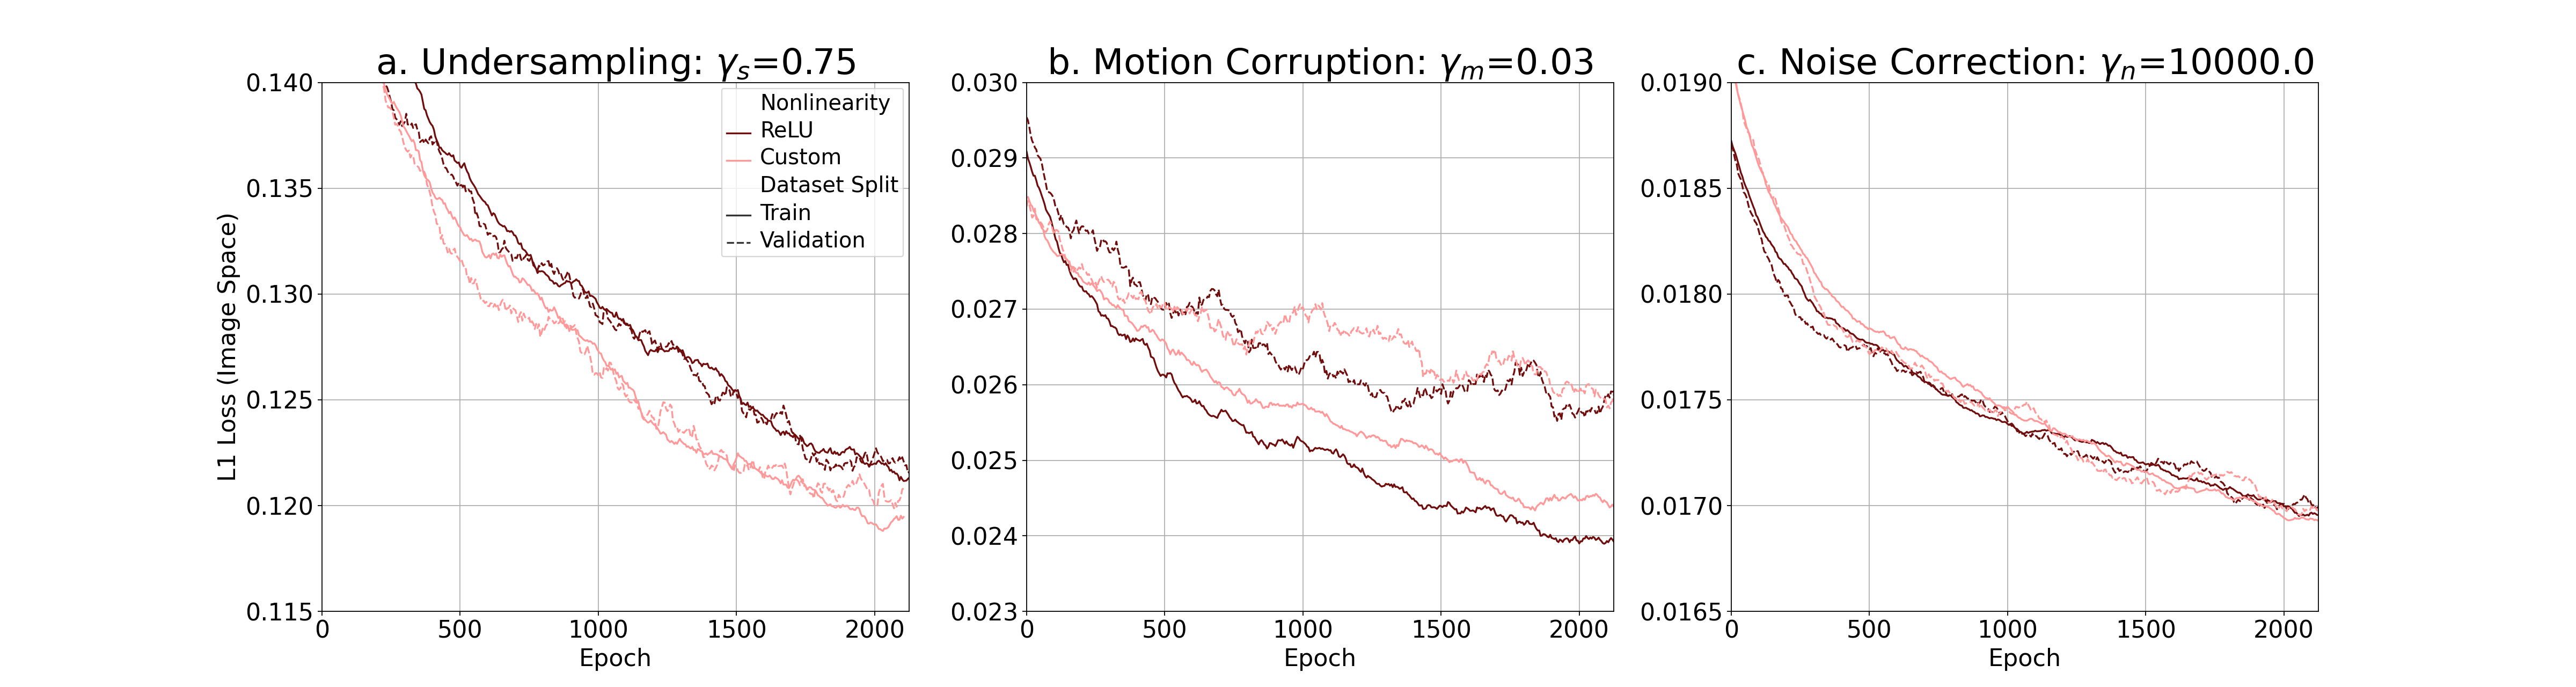

In [472]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig,axes = plt.subplots(1,3,figsize=(30,8))
    corruption_fracs =['0.75','0.03','10000.0']
    for i in range(3):
        task = tasks[i]
        exp = 'nonlinear_comparison_'+task
        ax = axes[i]
        g = plot_df(ax,[train_img_l1,val_img_l1],['Train','Validation'],task)    
        ax.grid()
        ax.set_xlim([0,2125])
        if(i==0):
            ax.set_ylim([0.115,0.14])
        elif(i==1):
            ax.set_ylim([0.023,0.03])
        elif(i==2):
            ax.set_ylim([0.0165,0.019])
        ax.set_xlabel('Epoch',fontsize=20)
        
        if(i==0):
            ax.set_ylabel('L1 Loss (Image Space)',fontsize=20)
        else:
            ax.set_ylabel('')

        corruption_frac=corruption_fracs[i]
        if('undersample' in task):
            title = 'a. Undersampling'
            gamma = r'$\gamma_s$'
        elif('motion' in task):
            title = 'b. Motion Corruption'
            gamma = r'$\gamma_m$'
        elif('denoise' in task):
            title = 'c. Noise Correction'
            gamma = r'$\gamma_n$'
        ax.set_title(title+': '+gamma+'='+str(corruption_frac),fontsize=30)
        ax.tick_params(labelsize=20)
        
        if(i==0):
            plt.setp(ax.get_legend().get_texts(), fontsize='18')
        if(i!=0):
            g.legend_.remove()
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nonlinearity_comparison.pdf',bbox_inches='tight')
